In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext lab_black
import torchvision
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

random_seed = 1
torch.manual_seed(random_seed)

In [30]:
batch_size = 2000

In [31]:
# To normalize we need the mean and std of our dataset
from tensorflow.keras.datasets import mnist

# Load,and set train and test data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
dataset = np.concatenate((X_train, X_test), axis=0)
dataset = dataset / 255
dataset_mean = dataset.mean()
dataset_std = dataset.std()
print(f"mean:{round(dataset_mean,4)}")
print(f"standard deviation:{round(dataset_std,4)}")

mean:0.1309
standard deviation:0.3084


In [32]:
# Load,and set train and test data
# Normalize the dataset
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "/files/",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((dataset_mean,), (dataset_std,)),
            ]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        "/files/",
        train=False,
        download=True,
        transform=torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((dataset_mean,), (dataset_std,)),
            ]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)

In [33]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

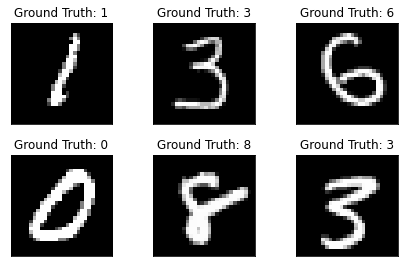

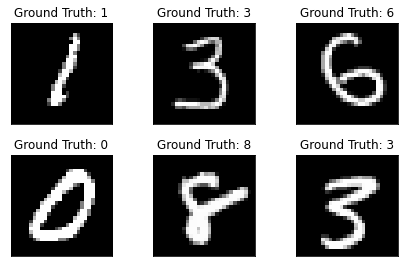

In [34]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    plt.title(f"Ground Truth: {example_targets[i]}")
    plt.xticks([])
    plt.yticks([])
fig

In [35]:
for batch, (X, y) in enumerate(train_loader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([2000, 1, 28, 28])
y shape: torch.Size([2000])


In [36]:
class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super(NeuralNetwork, self).__init__()
        # Default padding=0 and stride =1
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=3)
        self.fc1 = nn.Linear(24 * 24, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        # input shape: [64, 1, 28, 28]
        # output shape: [64, 1, 26, 26]
        x = F.relu((self.conv1(x)))

        # input shape: [64, 1, 26, 26]
        # output shape: [64, 1, 24, 24]
        x = F.relu(self.conv2(x))

        # flatten input shape: [64, 1, 24, 24]
        # output shape: [64, 24*24]
        x = x.view(-1, 24 * 24 * 1)

        # input shape: [64, 24*24]
        # output shape: [64, 50]
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)

        # input shape: [64, 50]
        # output shape: [64, 10]
        x = self.fc2(x)
        softmax = F.log_softmax(x, 1)
        return softmax

In [37]:
# Hyperparameters
epochs = 100
learning_rate = 0.01
momentum = 0.5
log_interval = 10

network = NeuralNetwork()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [38]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(epochs + 1)]

In [39]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100.0 * batch_idx / len(train_loader):.2f}%)]\tLoss: {loss.item():.5f}",
            )
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset))
            )
            torch.save(network.state_dict(), "./results/model.pth")
            torch.save(optimizer.state_dict(), "./results/optimizer.pth")

In [40]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(
        f"\nTest set: Avg. loss: {test_loss:.5f}, Accuracy: {correct}/{len(test_loader.dataset)} ({(100.0 * correct / len(test_loader.dataset)):.2f}%)\n"
    )

In [41]:
test()
for epoch in range(1, epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 2.30533, Accuracy: 902/10000 (9.02%)

Train Epoch: 1 [0/60000 (0.00%)]	Loss: 2.30380
Train Epoch: 1 [20000/60000 (33.33%)]	Loss: 2.30348
Train Epoch: 1 [40000/60000 (66.67%)]	Loss: 2.30577

Test set: Avg. loss: 2.30480, Accuracy: 1037/10000 (10.37%)

Train Epoch: 2 [0/60000 (0.00%)]	Loss: 2.30471
Train Epoch: 2 [20000/60000 (33.33%)]	Loss: 2.30417
Train Epoch: 2 [40000/60000 (66.67%)]	Loss: 2.30475

Test set: Avg. loss: 2.30432, Accuracy: 1122/10000 (11.22%)

Train Epoch: 3 [0/60000 (0.00%)]	Loss: 2.30242
Train Epoch: 3 [20000/60000 (33.33%)]	Loss: 2.30344
Train Epoch: 3 [40000/60000 (66.67%)]	Loss: 2.30326

Test set: Avg. loss: 2.30390, Accuracy: 1045/10000 (10.45%)

Train Epoch: 4 [0/60000 (0.00%)]	Loss: 2.30430
Train Epoch: 4 [20000/60000 (33.33%)]	Loss: 2.30343
Train Epoch: 4 [40000/60000 (66.67%)]	Loss: 2.30368

Test set: Avg. loss: 2.30353, Accuracy: 1032/10000 (10.32%)

Train Epoch: 5 [0/60000 (0.00%)]	Loss: 2.30172
Train Epoch: 5 [20000/60000 (33.33%)]	Los

C:\Users\jsandh\AppData\Local\Temp\ipykernel_32116\102117087.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


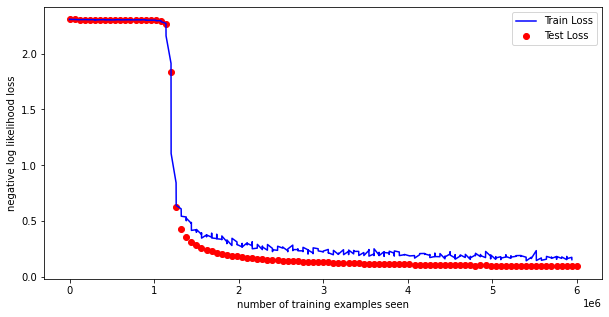

In [42]:
fig = plt.figure(figsize=(10, 5))
plt.plot(train_counter, train_losses, color="blue")
plt.scatter(test_counter, test_losses, color="red")
plt.legend(["Train Loss", "Test Loss"], loc="upper right")
plt.xlabel("number of training examples seen")
plt.ylabel("negative log likelihood loss")
fig.show()

In [43]:
with torch.no_grad():
    output = network(example_data)

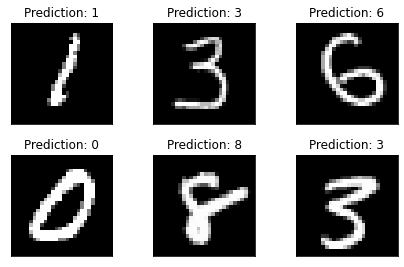

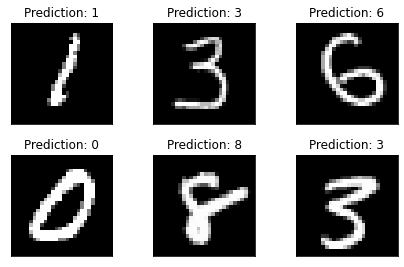

In [44]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
fig

In [45]:
# Continued training
continued_network = NeuralNetwork()
continued_optimizer = optim.SGD(
    network.parameters(), lr=learning_rate, momentum=momentum
)

In [46]:
network_state_dict = torch.load("./results/model.pth")
continued_network.load_state_dict(network_state_dict)
optimizer_state_dict = torch.load("./results/optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)